# Problema: Churn Modeling

El ejercicio para este blog está enfocado a nivel empresarial al tema de la pérdida de clientes, prácticamente consiste en un modelo predictivo que estima, a nivel de cliente la propensión que tiene de irse o abandonar un producto o servicio. Para un cliente dado, se determina mediante un algoritmo de clasificación binaria la probabilidad de pertenecer a una clase, se divide a los clientes en dos grupos (output del modelo): los que se van y los que no, así como también la probabilidad de pertenecer a cada grupo.
La relevancia de este modelo, es porque permite focalizar el análisis de saber que clientes corren el mayor riesgo de irse, por lo que se puede orientar los esfuerzos a ese rescate.

El conjunto de datos a utilizar contiene detalles de los clientes de un banco y la variable objetivo es una variable binaria que refleja el hecho de si el cliente abandonó el banco (cerró su cuenta) o sigue siendo un cliente. El dataset utilizado esta en formato *CSV* (comma-separated values) y fue obtenido de la pagina kaggle, es un problema tipico que podemos encontrar para aprender y practicar algoritmos de Machine Learning.


**Autor: Samuel Cortez**

**Se importan librerías a utilizar para el problema de Clasificación**

In [2]:
# Tratamiento de datos
import pandas as pd
import numpy as np
import math
import missingno as msno

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from subplots_hist import visualizacion_sns

# Sistema
import os
from pathlib import Path

# Preprocesamiento / ML
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# xgboost - Ensemble Methods
from xgboost import XGBClassifier, plot_importance

# Pipeline, compose sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,10)

**Carga del dataset**

In [4]:
#Path Dataset a utilizar
path_customer = 'Churn_Modelling.csv' 
dataset_df = pd.read_csv(filepath_or_buffer=path_customer,
                         sep = ',',
                         index_col = None,
                         header=0,
                         encoding='utf-8')
dataset_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
dataset_df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


**Información del dataset**

In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


El dataframe contiene 14 columnas: 3 variables con de tipo dato 'object' y 11 numéricas, y 10,000 renglones.

**Análisis de datos nulos**

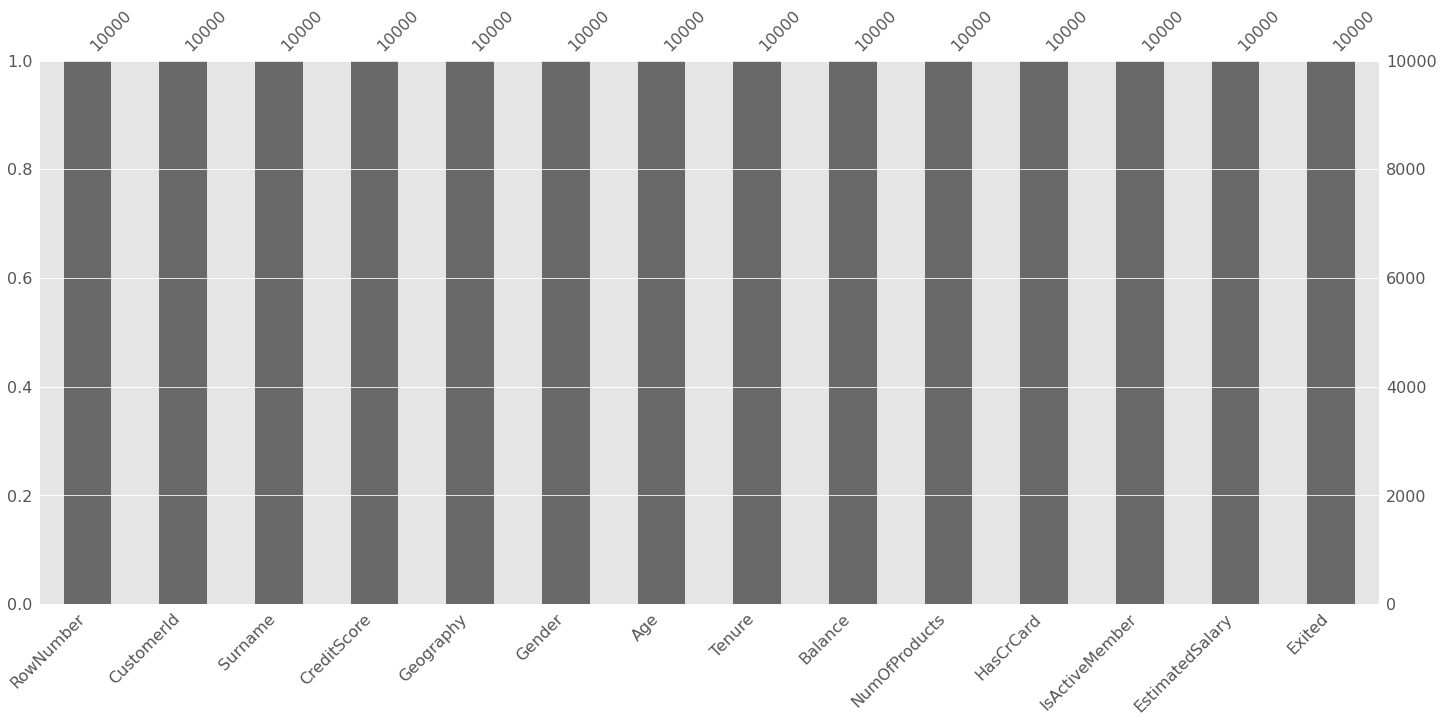

In [7]:
ax_missing = msno.bar(df = dataset_df)
plt.show()

In [8]:
dataset_df.isnull().sum(axis = 0)

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No se observan datos faltantes en las variables, es un dataset muy trabajado anteriormente por la comunidad.

## Análisis Exploratorio de Datos (EDA)

**Selección de variable por tipo de dato**

In [10]:
cols_num = dataset_df.select_dtypes(include=np.number).columns.tolist()
cols_num

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [11]:
cols_non_num = dataset_df.select_dtypes(exclude=np.number).columns.tolist()
cols_non_num

['Surname', 'Geography', 'Gender']

Se identifican las etiquetas de las variables numéricas y de tipo object (texto ó secuencia de caracteres)

**Resumen de estadísticos**

Variables numéricas

In [12]:
dataset_df.describe(include = np.number)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Variables Categóricas

In [13]:
dataset_df.describe(include = 'object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


**Análisis de la distribución y dispersión de los datos con Boxplots**

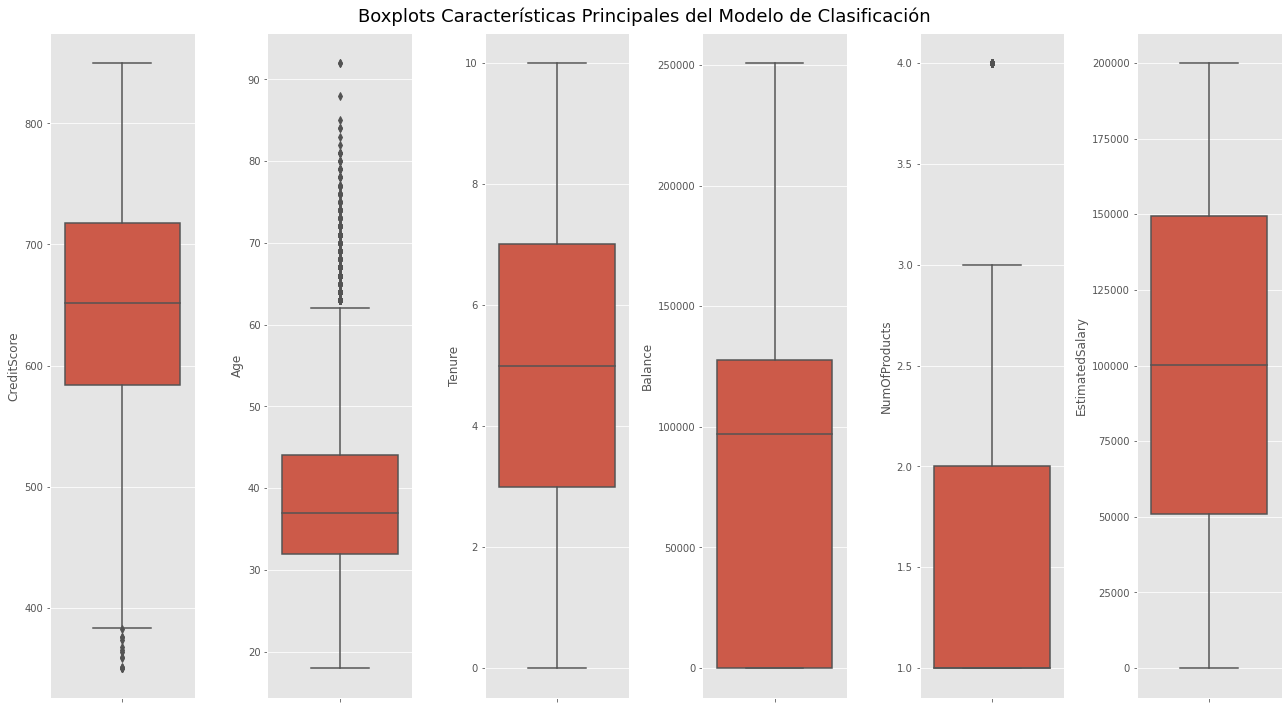

In [14]:
features_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','EstimatedSalary']
fig_boxplots, ax_box = plt.subplots(nrows = 1, ncols = len(features_list))
fig_boxplots.suptitle('Boxplots Características Principales del Modelo de Clasificación', fontsize = 18)
for i, col in enumerate(features_list):
    sns.boxplot(data = dataset_df, y= col, ax = ax_box[i])
plt.tight_layout()
plt.show()

**Análisis de Distribución mediante Histogramas**

In [15]:
vis_feat = visualizacion_sns(y_min=0,y_max=700)

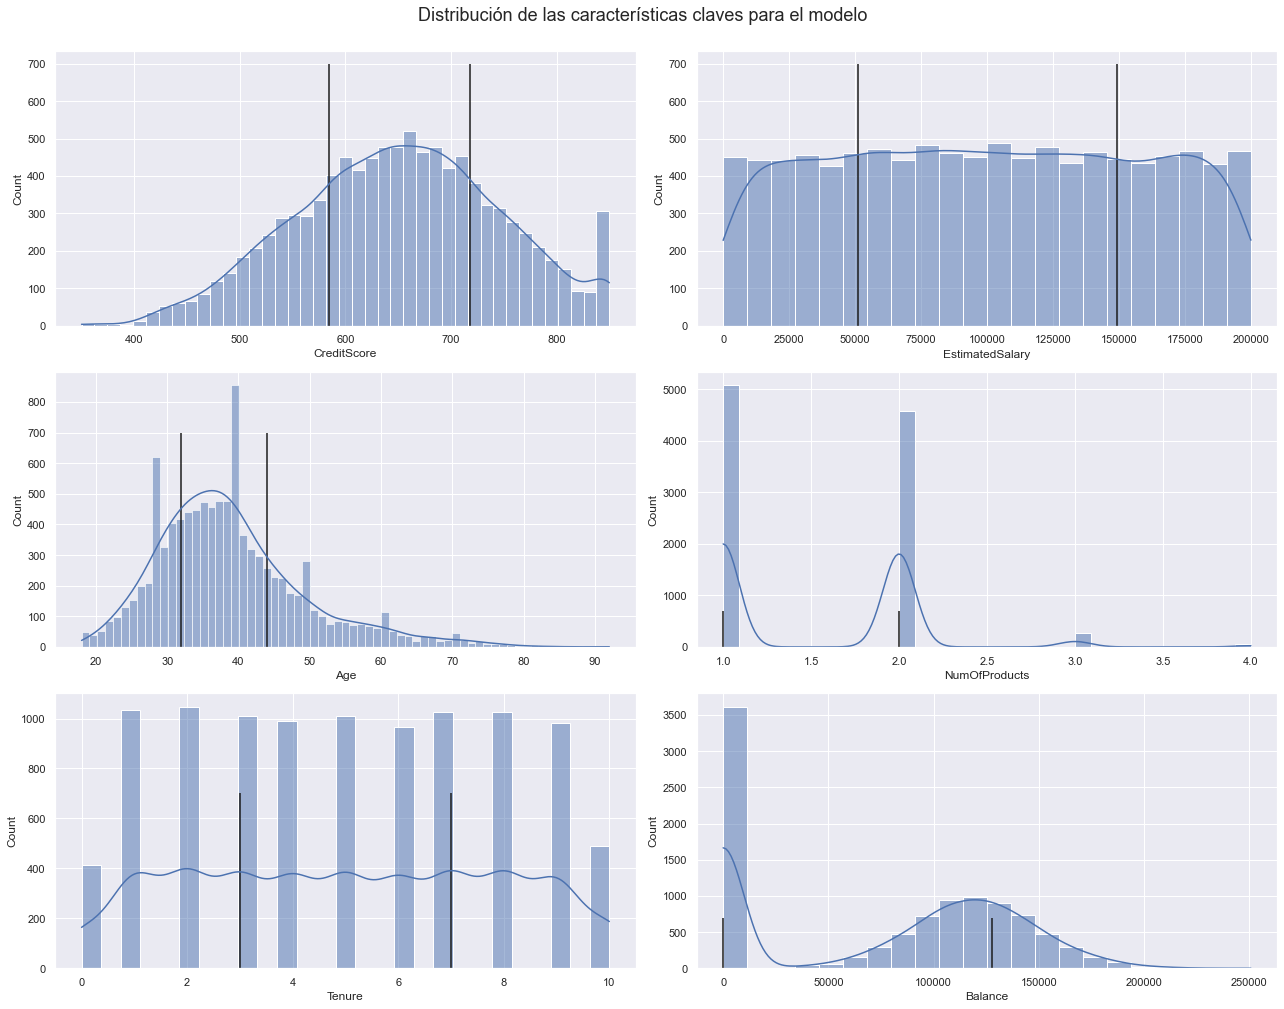

In [16]:
title_ = 'Distribución de las características claves para el modelo'
vis_feat.sns_vis_subplots(df=dataset_df, col_list=features_list, title = title_)

* En los histogramas y boxplots se observan distribuciones muy **sesgadas** para edad, creditscore, Balance, y no así para Estimated Salary y Tenure. Hay presencia de outliers para edad, credit score y Num of Products. Para las variables de Tenure y Num Of Products se tienen histogramas con datos discretos.


**Distribuciones por categoría de resultado**

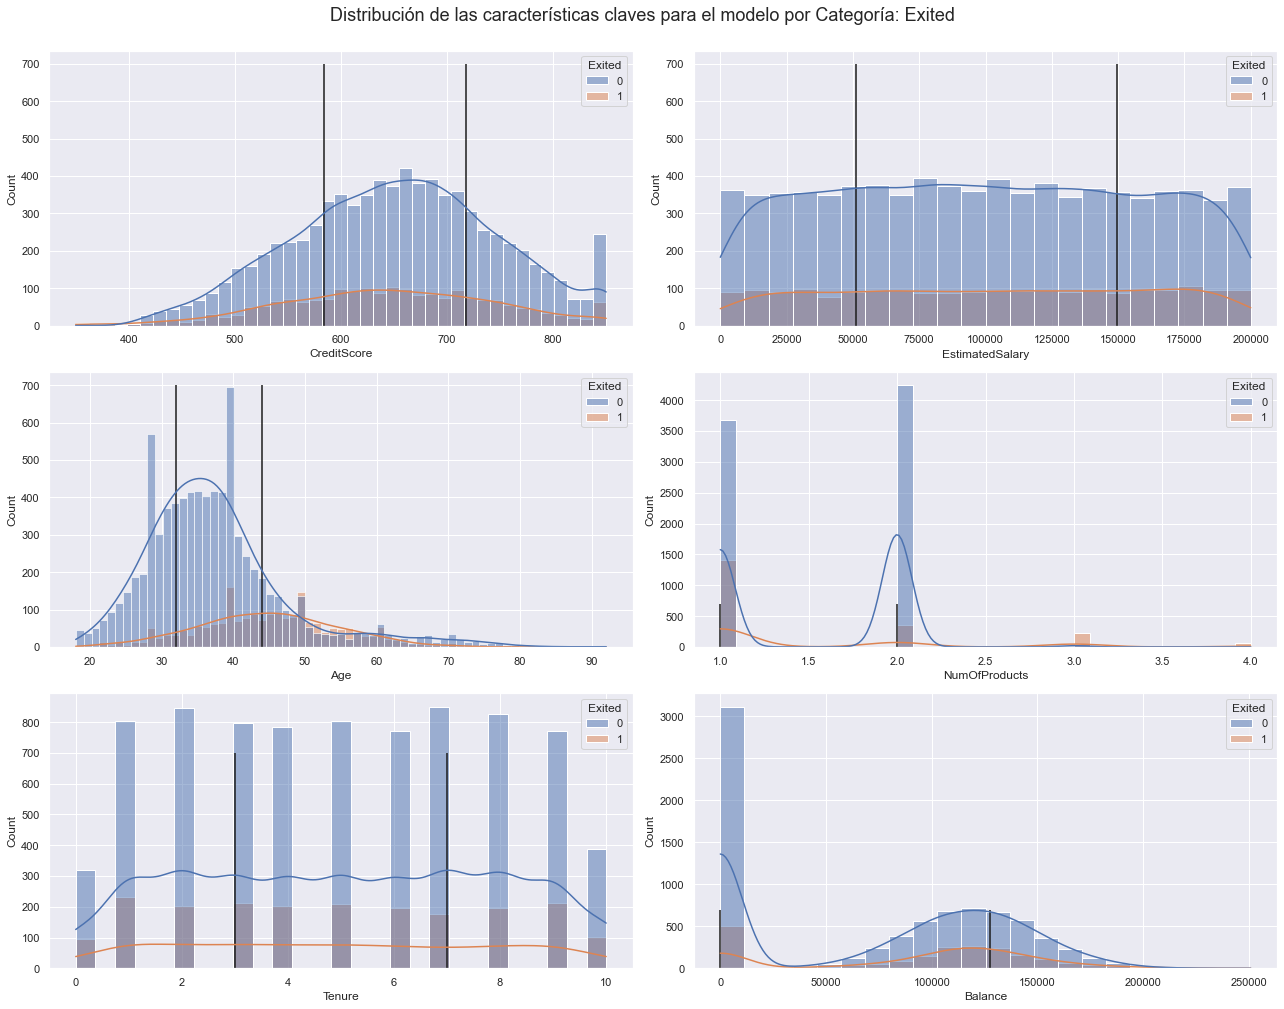

In [17]:
title_cat = 'Distribución de las características claves para el modelo por Categoría: Exited'
vis_feat.sns_vis_subplots(df=dataset_df, col_list=features_list, title = title_cat, categoria= 'Exited')

Mediana de la variable de Age (Edad) para las distribuciones categorizadas por Exited (abandono o salida)

Para la variable de Exited se entiende por 0: No abandono del servicio/producto/suscripción, y por 1 el si abandono.

In [94]:
dataset_df.groupby('Exited').describe()['Age']

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.0,37.408389,10.125363,18.0,31.0,36.0,41.0,92.0
1,2037.0,44.837997,9.761562,18.0,38.0,45.0,51.0,84.0


* Se observa que para la variable de edad la mediana de la categoría de abandono es mayor que la de no abandono.

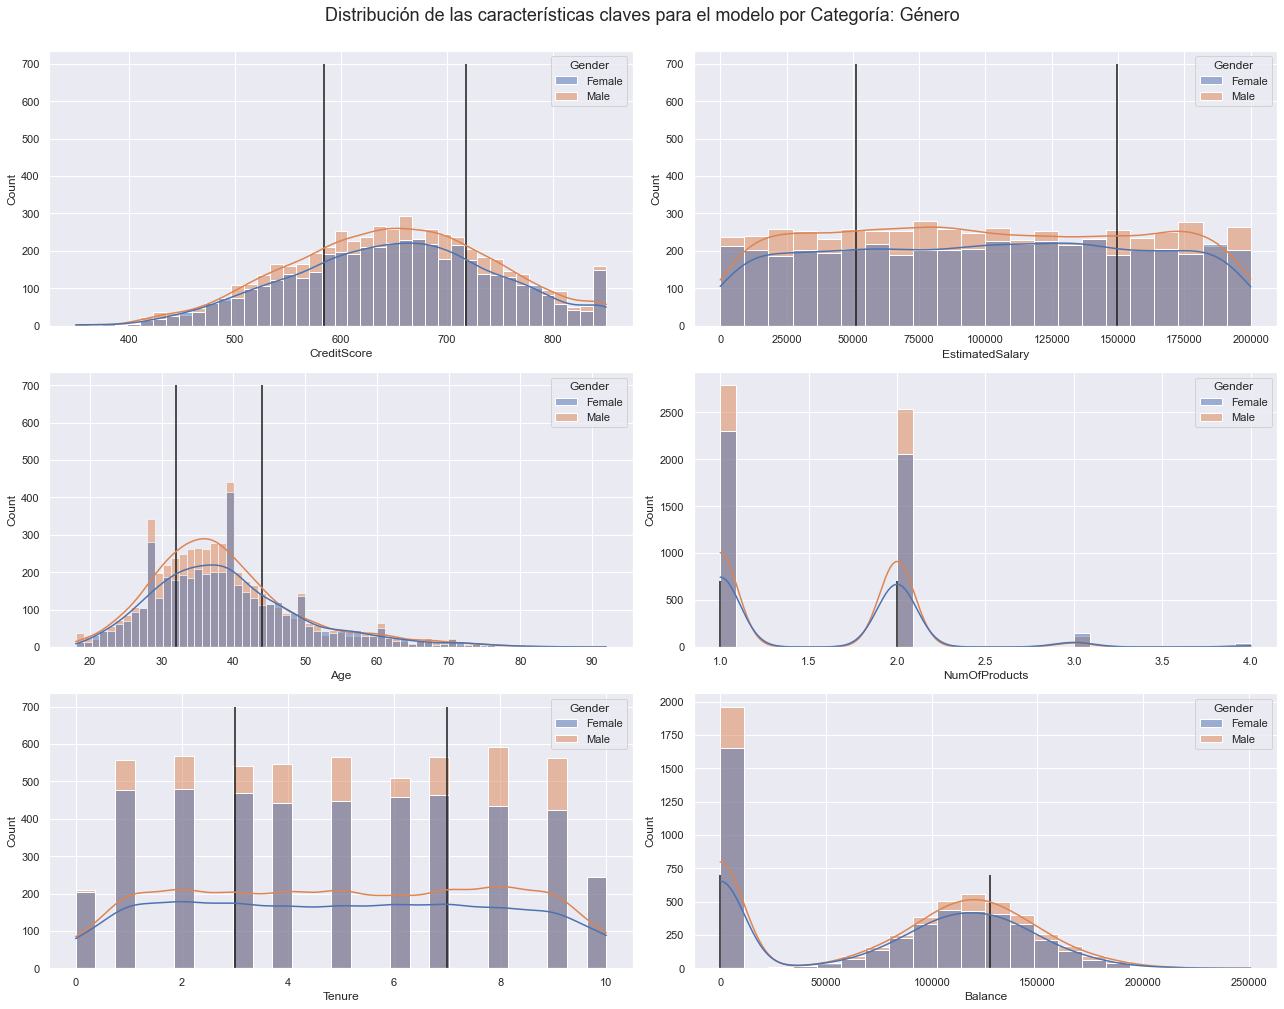

In [18]:
title_cat = 'Distribución de las características claves para el modelo por Categoría: Género'
vis_feat.sns_vis_subplots(df=dataset_df, col_list=features_list, title = title_cat, categoria= 'Gender')

* No se observan de forma gráfica aparente diferencias en las distribuiciones de las variables para las categorías de Género.

**Balance de datos por categorías**

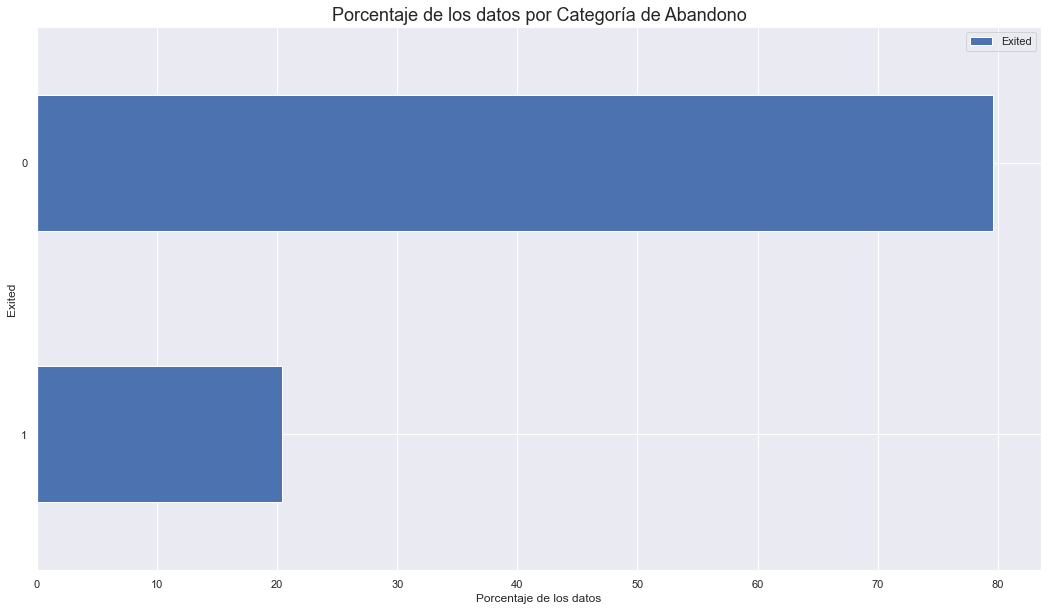

In [91]:
Exited_size = 100*dataset_df.Exited.value_counts(normalize = True, ascending =True)
ax_exited = Exited_size.plot(kind = 'barh',
                             xlabel = 'Exited',
                             legend = True)

ax_exited.set_title('Porcentaje de los datos por Categoría de Abandono', fontsize = 18)
ax_exited.set_xlabel('Porcentaje de los datos')
plt.show()

Se observa un desbalance de los datos para la variable que se definirá mas adelante en el modelo como output (salida).

**Agrupamiento por región geográfica**

In [21]:
dataset_group = dataset_df.groupby('Geography')

Text(0.5, 0, '# instancias por zona geográfica')

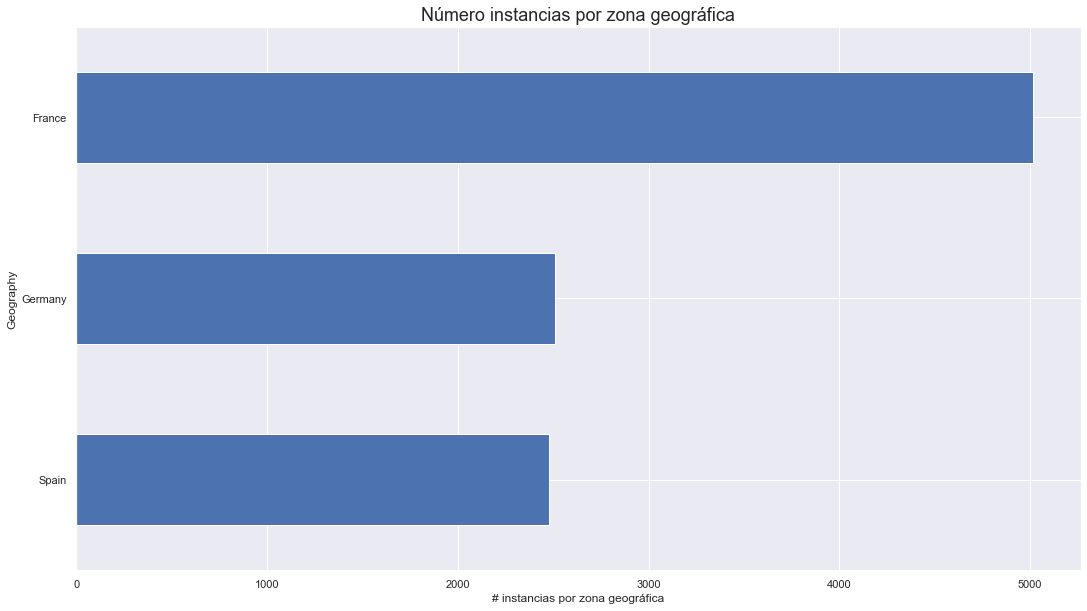

In [22]:
ax_geo = dataset_group.size().sort_values(ascending=True).plot(kind = 'barh',
                                                               grid = True)
ax_geo.set_title('Número instancias por zona geográfica', fontsize = 18)
ax_geo.set_xlabel( '# instancias por zona geográfica')

Se observan mayor cantidad de instancias para Francia, en el caso de alemania y España son muy parecidas.

In [23]:
dataset_group_gex = dataset_df.groupby(['Geography','Exited'])

In [24]:
dataset_group_gex_df = dataset_group_gex.size().reset_index().rename(columns = {0:'count'})

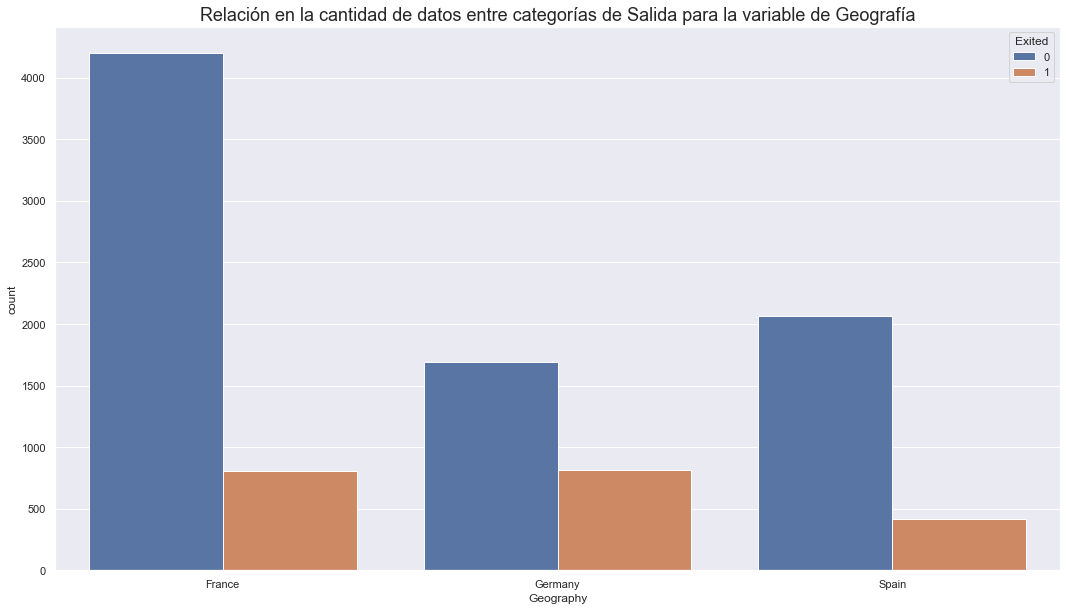

In [96]:
ax_barplot = sns.barplot(data = dataset_group_gex_df, x='Geography', y = 'count', hue = 'Exited')
ax_barplot.set_title('Relación en la cantidad de datos entre categorías de Salida para la variable de Geografía', fontsize = 18)
plt.show()

Las clases entre abandono y no abandono por país estan desbalanceadas, teniendo mayor cantidad la de no abandono.

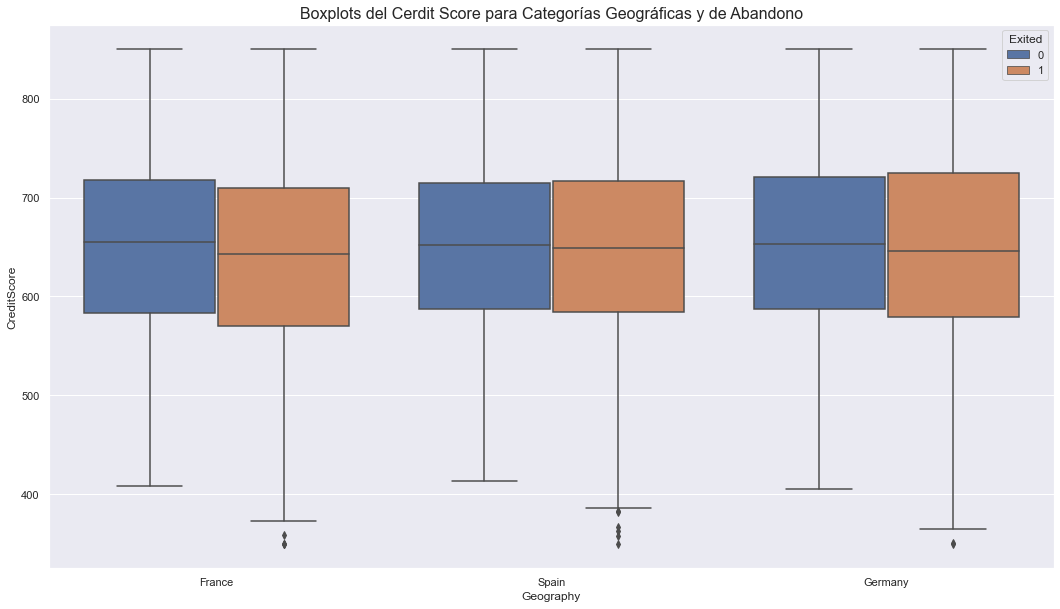

In [97]:
ax_boxplt_geo_cred = sns.boxplot(data = dataset_df, x = 'Geography', y = 'CreditScore', hue = 'Exited')
ax_boxplt_geo_cred.set_title('Boxplots del Cerdit Score para Categorías Geográficas y de Abandono', fontsize = 16)
plt.show()

Faltaría hacer una prueba de hipotesis para corroborar las diferencias entre distribuciones por categorías de Salida en cada País para la variable de Credit Score, que no es el alcance de este ejercicio. Aun así, se observa una diferencia más evidente en la mediana (Q2) para Francia en el credit score para las personas que abandonan y las que no, que en comparación del resto de países.

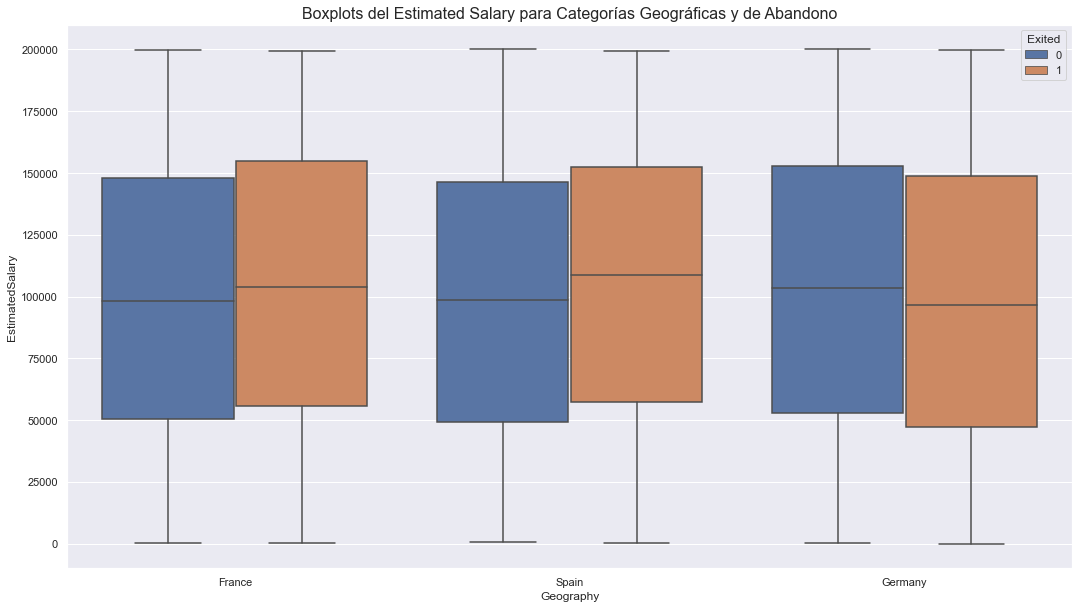

In [98]:
ax_boxplt_geo_cred = sns.boxplot(data = dataset_df, x = 'Geography', y = 'EstimatedSalary', hue = 'Exited')
ax_boxplt_geo_cred.set_title('Boxplots del Estimated Salary para Categorías Geográficas y de Abandono', fontsize = 16)
plt.show()

**Matriz de Correlación de Pearson**

In [28]:
corr_ = dataset_df.select_dtypes(include=[np.number]).corr(method  = 'pearson')
mask_corr = np.triu(np.ones_like(corr_, dtype = bool))

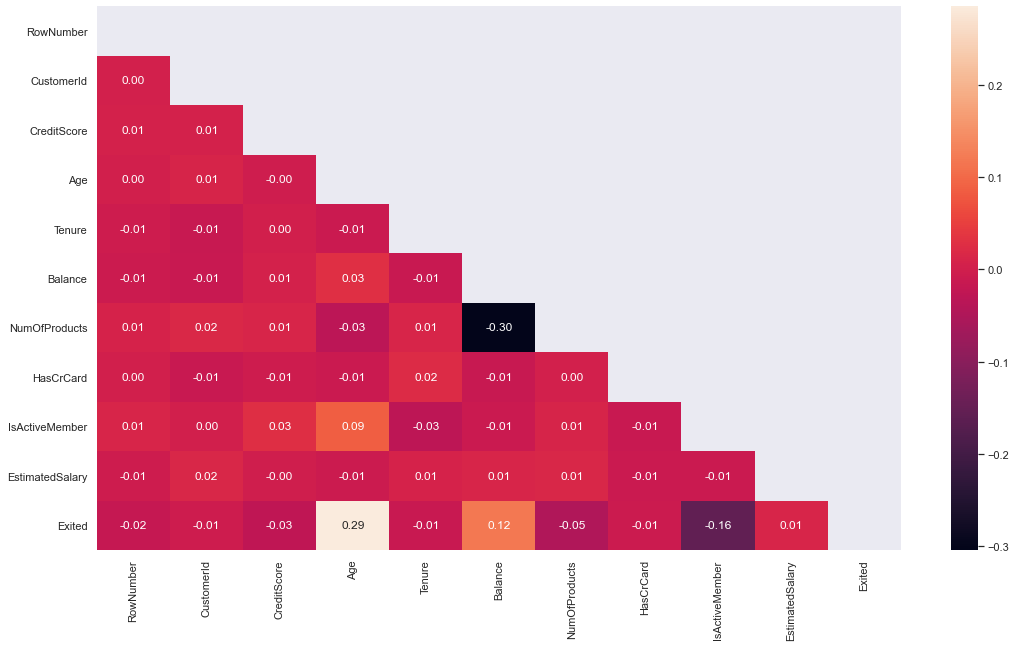

In [29]:
ax_corr = sns.heatmap(data = corr_, annot = True, fmt = '.2f', mask = mask_corr)
plt.show()

No se observan relaciones lineales altas o significativas en el coeficiente de correlación para las variables numéricas.

### **Desarrollo del Modelo de ML: XGBoost**

**Preprocesamiento de datos**

Se eliminan variables en el dataframe que no tienen relevancia en el modelo.

In [30]:
dataset_df.drop(columns=['RowNumber','CustomerId','Surname'], inplace = True)

**train test split**

Se divide el dataset en los conjuntos de entrenamiento y prueba.

In [32]:
X = dataset_df.iloc[:,:-1]
y = dataset_df.iloc[:,[-1]]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 111, stratify = y )

Selección del conjunto de entrenamiento: Características (Inputs) y salida (output) del modelo de clasificación binaria.

Features numéricos:

In [34]:
feat_num = dataset_df.drop(columns='Exited').select_dtypes(include=[np.number]).columns.tolist()
feat_cat = dataset_df.select_dtypes(include=['object']).columns.tolist()

Pipeline para columnas categoricas
- One Hot Encoder

In [35]:
#One-Hot Encoding para transformar de variables categóricas a un arreglo numérico
cat_pipeline = make_pipeline(
    OneHotEncoder(categories='auto'
                  ,handle_unknown='ignore',
                  sparse = False)
    )

Pipeline para columnas numericas

In [36]:
num_pipeline = make_pipeline(
    StandardScaler()
    )

Se combinan ambos pipelines

In [37]:
comb_pipeline = ColumnTransformer([
    ('num',num_pipeline,feat_num),
    ('cat',cat_pipeline,feat_cat)
])

**Se construye el modelo en un Pipeline: Preprocesamiento + Modelo XGBoost**

In [38]:
xgb_pipeline = Pipeline(
    [('comb_pipeline',comb_pipeline), 
    ('xgb_model',XGBClassifier(objective ='binary:logistic', 
                               booster = 'gbtree',
                               eval_metric='error',
                               use_label_encoder=False))])

Diccionario con los arreglos de hiperparámetros por ajustar.

In [73]:
xgb_params = {
        "xgb_model__n_estimators": [10,50,80,100],
        "xgb_model__max_depth": [3, 4, 5, 6, 8, 10, 12],
        "xgb_model__learning_rate": [ 0.10, 0.15, 0.20, 0.25, 0.30],
        "xgb_model__gamma": [0.1, 0.2, 0.3, 0.4],
        "xgb_model__min_child_weight": [1, 3, 5, 7],
        "xgb_model__colsample_bytree": [0.3, 0.4, 0.5, 0.7],
        
        }

**Ajuste de Hiperparámetros de xgboost con Randomized Search CV**

In [74]:
xgb_rs_cv = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_params,
    n_iter = 5,
    scoring = 'accuracy',
    cv = 5,
    verbose=1)

**Ajuste del modelo xgboost**

In [75]:
xgb_rs_cv.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.2s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('comb_pipeline',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'HasCrCard',
                                          

Mejor puntuación del modelo ajustado: promedio del cross validation para el conjunto de validación.

In [76]:
xgb_rs_cv.best_score_

0.8643750000000001

Lista con las etiquetas de las caracteristicas categoricas transformadas por one hot encoder en el pipeline

In [77]:
cat_feat_labels = xgb_rs_cv.best_estimator_.\
    named_steps['comb_pipeline'].\
    transformers_[1][1].\
        named_steps['onehotencoder'].\
            get_feature_names()\
                .tolist()
cat_feat_labels

['x0_France', 'x0_Germany', 'x0_Spain', 'x1_Female', 'x1_Male']

Lista con las características númericas

In [78]:
num_feat_labels = xgb_rs_cv.best_estimator_.\
    named_steps['comb_pipeline'].\
        transformers_[0][2]
num_feat_labels

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

Lista con las características completas

In [79]:
feat_labels = num_feat_labels + cat_feat_labels

Importancia de características del modelo

In [80]:
dict_feat_labels = dict(enumerate(feat_labels))
dict_feat_labels

{0: 'CreditScore',
 1: 'Age',
 2: 'Tenure',
 3: 'Balance',
 4: 'NumOfProducts',
 5: 'HasCrCard',
 6: 'IsActiveMember',
 7: 'EstimatedSalary',
 8: 'x0_France',
 9: 'x0_Germany',
 10: 'x0_Spain',
 11: 'x1_Female',
 12: 'x1_Male'}

In [81]:
dict_weight_import = xgb_rs_cv.best_estimator_.named_steps['xgb_model'].get_booster().get_score(importance_type='weight')
dict_weight_import

{'f0': 79.0,
 'f1': 127.0,
 'f2': 45.0,
 'f3': 96.0,
 'f4': 55.0,
 'f5': 8.0,
 'f6': 20.0,
 'f7': 73.0,
 'f8': 15.0,
 'f9': 20.0,
 'f10': 14.0,
 'f11': 30.0,
 'f12': 15.0}

In [82]:
dict_FI = {dict_feat_labels.get(j):dict_weight_import.get(element) for j, element in enumerate(list(dict_weight_import))}
FI_XGBoost_s = pd.Series(dict_FI, name='Feature_Importance')

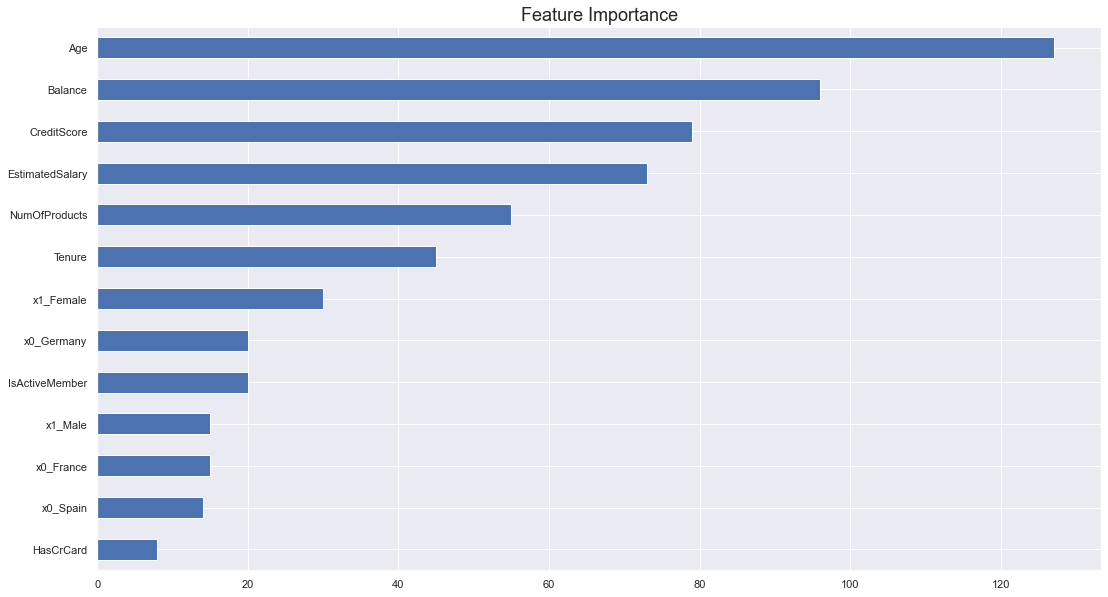

In [83]:
ax_IF = FI_XGBoost_s.sort_values(ascending=True).plot(kind = 'barh',
                                                        x = 'features',
                                                        y = 'importance')
ax_IF.set_title('Feature Importance', fontsize = 18)
plt.show()

**El mejor modelo ajustado**

In [85]:
xgb_rs_cv.best_estimator_.named_steps['xgb_model']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, eval_metric='error', gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

**Resultados conjunto de entrenamiento y prueba**

In [86]:
print(f'Accuracy del Clasificador xgboost en el conjunto de entrenamiento:{xgb_rs_cv.score(X=X_train,y=y_train)}')

Accuracy del Clasificador xgboost en el conjunto de entrenamiento:0.87525


In [87]:
print(f'Accuracy del Clasificador xgboost en el conjunto de prueba:{xgb_rs_cv.score(X=X_test,y=y_test)}')

Accuracy del Clasificador xgboost en el conjunto de prueba:0.859


**Matriz de Confusión**

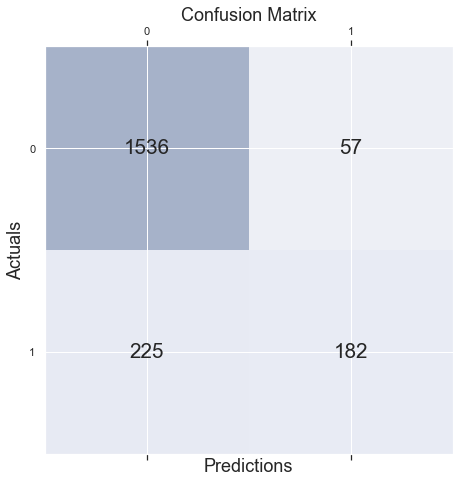

In [88]:
# Calculo de la matriz de confusión conjunto de prueba
conf_matrix = confusion_matrix(y_true=y_test, y_pred=xgb_rs_cv.predict(X_test))

# Matriz de Confusión
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [89]:
print(classification_report(y_test,xgb_rs_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.45      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



**Conclusión:**
* Se obtiene en el accuracy del modelo un resultado de 0.86 que es aceptable, pero se observa en la métrica de recall para la categoría 1 en el conjunto de prueba un valor bajo de 0.45, esto es debido al desbalance de clases en la variable de salida. Faltaría aplicar algún método de remuestreo para el balanceo de clases.
* El modelo no presenta **overfitting**, ni **underfitting**, se comprobó con la medición del score para el conjunto de prueba y se comparó con la de entrenamiento, además de revisarlo con el resultado entregado en el score (media de todos los scores en la evaluaciones) aplicando cross validation con cv = 5 para validación del modelo.